### Set up Pyro connection to the board
``soc`` and ``soccfg`` live on the board, and we interact with them through pyro proxy objects.  This section of code connects to the pyro server running on the board to receive these objects

In [43]:
## ------------------------------------------------ ##
import Pyro4
from qick import *

Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

ns_host = "192.168.137.93"
ns_port = 8883
proxy_name = "DMQIS_qick"
ns = Pyro4.locateNS(host=ns_host, port=ns_port)

for k,v in ns.list().items():
    print(k,v)

soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
#print(soccfg)
## ------------------------------------------------ ##

Pyro.NameServer PYRO:Pyro.NameServer@192.168.137.93:8883
DMQIS_qick PYRO:obj_8a18b384aecc4e1d939860471324ce0e@192.168.137.103:42509


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from qick import *
import sys
sys.path.append('./Libraries')
from qick_data import *
from qick_helpers import *
from qick_programs import *
import tqdm


datapath = 'c:\\_Data\\Hannah\\SQUAT_T1_5-15-2024'

### Quick Frequency Scan

In [45]:
## Initialize a measurement object
## This object holds dictionaries
## Not much else to it.  Just a container that handles export/import
meas = QICKdata()

## Next we fill the metadata dictionary
meas.set_metadata(device="C11", qubits=["1"], meas_type="freq_scan")

## Then specify the connection channels
meas.set_hw_cfg(res_ch=transmission_ch, qu_ch=None, ro_ch=ro_ch)
#meas.hw_cfg["LO_power"] = 16
#meas.hw_cfg["LO_freq"] = 4500
## Finally specify pulse parameters
meas.meas_cfg = {"relax_delay_us" : 0,
            "adc_trig_offset"  : 160,
            "readout_length_us"   : 20, #0.2,
   
            "res_style"     : "const",
            "res_gain"      : 2000, #30000,
            "res_length_us" : 20, #0.279,
            "res_phase"     : 0,
            ## commenting out because this is a freq scan
            ## "res_freq" : 3000, ## MHz

            "reps"          : 700,   ## Averages in firmware
            "soft_avgs"     : 1,      ## Averages in software
       }

## Convert time variables from us to clock ticks
meas = convert_time_vars(soccfg, meas)
print(meas)

## Set up sweep values
RF_freqs = np.linspace(7340, 7365, num=400)
Ivals = np.zeros(len(RF_freqs))
Qvals = np.zeros(len(RF_freqs))

## Initialize a program
## Give it config dictionaries from the measurement class
config = {**meas.hw_cfg, **meas.meas_cfg}
for i, f in enumerate(tqdm.tqdm(RF_freqs)):
    config["res_freq"] = f
    prog =oneTonePulse(soccfg, config)
    [[I]], [[Q]] = prog.acquire(soc)
    Ivals[i] = I
    Qvals[i] = Q

##  IMPORTANT make sure you save the data
meas.meas_data = {"RF_freqs" : RF_freqs, "Ivals" : Ivals, "Qvals" : Qvals}
meas.write_H5('c:\\_Data\\Hannah\\SQUAT_freqscan')

Creating dataset with series 20240517_133021
converting time variables from us to clock ticks
====---------------------------====
         20240517_133021
====---------------------------====
       Device =  C11
       Qubits =  ['1']
    Meas Type =  freq_scan
====---------------------------====
20240517_133021


100%|██████████| 400/400 [00:10<00:00, 36.54it/s]

Saving data as: 20240517_133021_freq_scan.h5


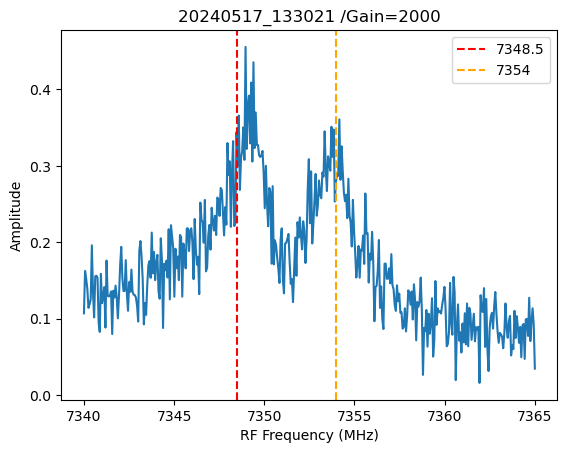

In [46]:
m1 = 7348.5
m2 = 7354

plt.plot(RF_freqs, np.sqrt(Ivals**2 + Qvals**2))
#plt.axvline(7358, color='r', linestyle='--', label='7350MHz')
plt.xlabel('RF Frequency (MHz)')
plt.ylabel('Amplitude')
plt.axvline(m1, color='r', linestyle='--', label=str(m1))
plt.axvline(m2, color='orange', linestyle='--', label=str(m2))
plt.legend()
plt.title(meas.meta['series'] + " /Gain=" + str(meas.meas_cfg['res_gain']))
plt.savefig('c:\\_Data\\Hannah\\SQUAT_freqscan' + '\\' + meas.meta['series'] + '_.png')

# Then T1 measurement

In [40]:
## Initialize a measurement object
meas = QICKdata()
meas.set_metadata(device="C11", qubits=["1"], meas_type="T1_roCB_pulseCB")
meas.set_hw_cfg(res_ch=transmission_ch, qu_ch=chargebias_ch, ro_ch=ro_ch)

## Specify pulse parameters
meas.meas_cfg = {"adc_trig_offset"  : 160,
    'qu_freq': m1,
    'qu_gain': 1500,
    'qu_length_us': 2,
    'qu_phase': 0,
    'qu_style': 'const',
    "delay_us" : 0.3,

    'readout_length': 65,
    'relax_delay': 215,
    'reps': 600000,

    'res_freq': m1,
    'res_gain': 2000,
    'res_length': 65,
    'res_phase': 0,
    'res_style': 'const',
    
    'soft_avgs': 1}
       

## Convert time variables from us to clock ticks
meas = convert_time_vars(soccfg, meas)
print(meas)

## Set up sweep values
delays_us = np.linspace(0.01, 0.5, num=70)
delays_clock_ticks = np.zeros(len(delays_us))
for i, l in enumerate(delays_us):
    delays_clock_ticks[i] = soccfg.us2cycles(l)

## Set up data arrays
Ivals = np.zeros(len(delays_clock_ticks))
Qvals = np.zeros(len(delays_clock_ticks))

config = {**meas.hw_cfg, **meas.meas_cfg}

for  j, l in enumerate(tqdm.tqdm(delays_clock_ticks)):
    config['delay'] = l
    prog = twoTonePulse(soccfg, config)
    [[I]], [[Q]] = prog.acquire(soc)
    Ivals[j] = I
    Qvals[j] = Q


##  IMPORTANT make sure you save the data
meas.meas_data = {"delays_us":delays_us,  "delays_clock_ticks" : delays_clock_ticks, "Ivals" : Ivals, "Qvals" : Qvals}
meas.write_H5(datapath)

Creating dataset with series 20240515_192601
converting time variables from us to clock ticks
====---------------------------====
         20240515_192601
====---------------------------====
       Device =  C11
       Qubits =  ['1']
    Meas Type =  T1_roCB_pulseCB
====---------------------------====
20240515_192601


  0%|          | 0/70 [00:00<?, ?it/s]

291616474 291616474


  1%|▏         | 1/70 [00:01<02:09,  1.87s/it]

291616474 291616474


  3%|▎         | 2/70 [00:03<02:07,  1.87s/it]

291616474 291616474


  4%|▍         | 3/70 [00:05<02:05,  1.88s/it]

291616474 291616474


  6%|▌         | 4/70 [00:07<02:04,  1.88s/it]

291616474 291616474


  7%|▋         | 5/70 [00:09<02:02,  1.88s/it]

291616474 291616474


  9%|▊         | 6/70 [00:11<02:00,  1.89s/it]

291616474 291616474


 10%|█         | 7/70 [00:13<01:59,  1.89s/it]

291616474 291616474


 11%|█▏        | 8/70 [00:15<01:57,  1.89s/it]

291616474 291616474


 13%|█▎        | 9/70 [00:17<01:55,  1.90s/it]

291616474 291616474


 14%|█▍        | 10/70 [00:18<01:54,  1.90s/it]

291616474 291616474


 16%|█▌        | 11/70 [00:20<01:52,  1.91s/it]

291616474 291616474


 17%|█▋        | 12/70 [00:22<01:50,  1.91s/it]

291616474 291616474


 19%|█▊        | 13/70 [00:24<01:49,  1.91s/it]

291616474 291616474


 20%|██        | 14/70 [00:26<01:47,  1.92s/it]

291616474 291616474


 21%|██▏       | 15/70 [00:28<01:45,  1.92s/it]

291616474 291616474


 23%|██▎       | 16/70 [00:30<01:44,  1.93s/it]

291616474 291616474


 24%|██▍       | 17/70 [00:32<01:42,  1.93s/it]

291616474 291616474


 26%|██▌       | 18/70 [00:34<01:40,  1.94s/it]

291616474 291616474


 27%|██▋       | 19/70 [00:36<01:38,  1.94s/it]

291616474 291616474


 29%|██▊       | 20/70 [00:38<01:37,  1.94s/it]

291616474 291616474


 30%|███       | 21/70 [00:40<01:35,  1.95s/it]

291616474 291616474


 31%|███▏      | 22/70 [00:42<01:33,  1.95s/it]

291616474 291616474


 33%|███▎      | 23/70 [00:44<01:31,  1.95s/it]

291616474 291616474


 34%|███▍      | 24/70 [00:46<01:30,  1.96s/it]

291616474 291616474


 36%|███▌      | 25/70 [00:48<01:28,  1.96s/it]

291616474 291616474


 37%|███▋      | 26/70 [00:50<01:26,  1.97s/it]

291616474 291616474


 39%|███▊      | 27/70 [00:52<01:24,  1.97s/it]

291616474 291616474


 40%|████      | 28/70 [00:54<01:23,  1.98s/it]

291616474 291616474


 41%|████▏     | 29/70 [00:56<01:21,  1.98s/it]

291616474 291616474


 43%|████▎     | 30/70 [00:58<01:19,  1.99s/it]

291616474 291616474


 44%|████▍     | 31/70 [01:00<01:17,  1.99s/it]

291616474 291616474


 46%|████▌     | 32/70 [01:02<01:15,  1.99s/it]

291616474 291616474


 47%|████▋     | 33/70 [01:04<01:13,  2.00s/it]

291616474 291616474


 49%|████▊     | 34/70 [01:06<01:12,  2.00s/it]

291616474 291616474


 50%|█████     | 35/70 [01:08<01:10,  2.01s/it]

291616474 291616474


 51%|█████▏    | 36/70 [01:10<01:08,  2.01s/it]

291616474 291616474


 53%|█████▎    | 37/70 [01:12<01:06,  2.01s/it]

291616474 291616474


 54%|█████▍    | 38/70 [01:14<01:04,  2.02s/it]

291616474 291616474


 56%|█████▌    | 39/70 [01:16<01:02,  2.03s/it]

291616474 291616474


 57%|█████▋    | 40/70 [01:18<01:00,  2.03s/it]

291616474 291616474


 59%|█████▊    | 41/70 [01:20<00:58,  2.03s/it]

291616474 291616474


 60%|██████    | 42/70 [01:22<00:57,  2.04s/it]

291616474 291616474


 61%|██████▏   | 43/70 [01:24<00:55,  2.04s/it]

291616474 291616474


 63%|██████▎   | 44/70 [01:26<00:53,  2.05s/it]

291616474 291616474


 64%|██████▍   | 45/70 [01:28<00:51,  2.05s/it]

291616474 291616474


 66%|██████▌   | 46/70 [01:30<00:49,  2.05s/it]

291616474 291616474


 67%|██████▋   | 47/70 [01:32<00:47,  2.06s/it]

291616474 291616474


 69%|██████▊   | 48/70 [01:34<00:45,  2.06s/it]

291616474 291616474


 70%|███████   | 49/70 [01:36<00:43,  2.07s/it]

291616474 291616474


 71%|███████▏  | 50/70 [01:38<00:41,  2.07s/it]

291616474 291616474


 73%|███████▎  | 51/70 [01:40<00:39,  2.07s/it]

291616474 291616474


 74%|███████▍  | 52/70 [01:42<00:37,  2.08s/it]

291616474 291616474


 76%|███████▌  | 53/70 [01:45<00:35,  2.08s/it]

291616474 291616474


 77%|███████▋  | 54/70 [01:47<00:33,  2.09s/it]

291616474 291616474


 79%|███████▊  | 55/70 [01:49<00:31,  2.09s/it]

291616474 291616474


 80%|████████  | 56/70 [01:51<00:29,  2.09s/it]

291616474 291616474


 81%|████████▏ | 57/70 [01:53<00:27,  2.10s/it]

291616474 291616474


 83%|████████▎ | 58/70 [01:55<00:25,  2.10s/it]

291616474 291616474


 84%|████████▍ | 59/70 [01:57<00:23,  2.11s/it]

291616474 291616474


 86%|████████▌ | 60/70 [01:59<00:21,  2.11s/it]

291616474 291616474


 87%|████████▋ | 61/70 [02:01<00:19,  2.12s/it]

291616474 291616474


 89%|████████▊ | 62/70 [02:04<00:16,  2.12s/it]

291616474 291616474


 90%|█████████ | 63/70 [02:06<00:14,  2.12s/it]

291616474 291616474


 91%|█████████▏| 64/70 [02:08<00:12,  2.13s/it]

291616474 291616474


 93%|█████████▎| 65/70 [02:10<00:10,  2.13s/it]

291616474 291616474


 94%|█████████▍| 66/70 [02:12<00:08,  2.14s/it]

291616474 291616474


 96%|█████████▌| 67/70 [02:14<00:06,  2.14s/it]

291616474 291616474


 97%|█████████▋| 68/70 [02:16<00:04,  2.15s/it]

291616474 291616474


 99%|█████████▊| 69/70 [02:19<00:02,  2.15s/it]

291616474 291616474


100%|██████████| 70/70 [02:21<00:00,  2.02s/it]

Saving data as: 20240515_192601_T1_roCB_pulseCB.h5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


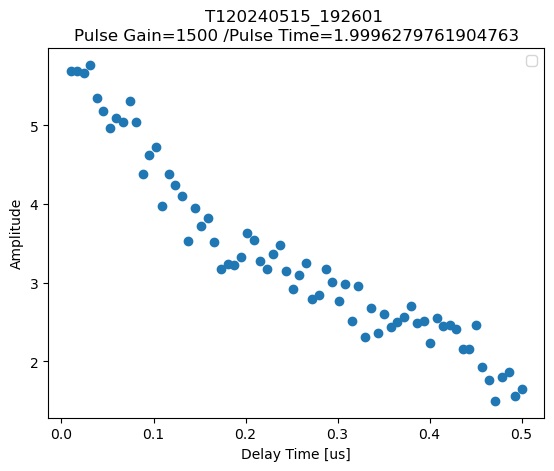

In [42]:
plt.scatter(delays_us, np.sqrt(Ivals**2 + Qvals**2))
#plt.axvline(7358, color='r', linestyle='--', label='7350MHz')
plt.xlabel('Delay Time [us]')
plt.ylabel('Amplitude')
plt.legend()
plt.title("T1" + meas.meta['series'] + " \nPulse Gain=" + str(meas.meas_cfg['qu_gain']) + " /Pulse Time=" + str(soccfg.cycles2us(meas.meas_cfg['qu_length'])))
plt.savefig(datapath + '\\' + meas.meta['series'] + '_.png')

In [ ]:
fn = "20240512_113845_T1_roCB_pulseCB.h5"
fp = "C:\\_Data\\Hannah\\SQUAT_T1\\20240512_113845_T1_roCB_pulseCB.h5"
readin = read_h5(fp, QICKdata)
print(readin)

# One tone sweep relax delay plot

In [ ]:
datapath2 = 'c:\\_Data\\Hannah\\SQUAT_OneTone'

## Initialize a measurement object
meas = QICKdata()
meas.set_metadata(device="C11", qubits=["1"], meas_type="onetone_sweep_relax_delay")
meas.set_hw_cfg(res_ch=chargebias_ch, qu_ch=chargebias_ch, ro_ch=ro_ch)

## Specify pulse parameters
meas.meas_cfg = {#"relax_delay_us" : 1,
            "adc_trig_offset_us"  : 0.506,
            "readout_length_us"   : 0.20, #0.2,
   
            "res_style"     : "const",
            "res_gain"      : 1000, #30000,
            "res_length_us" : 0.20, #0.279,
            "res_phase"     : 0,
            "res_freq"      : m1, ## MHz  
            
            "reps"         : 800000,   ## Averages in firmware
            "soft_avgs"    : 1,      ## Averages in software
       }

## Convert time variables from us to clock ticks
meas = convert_time_vars(soccfg, meas)
print(meas)

## Set up sweep values
delays_us = np.linspace(0.1, 12, num=300)
delays_clock_ticks = np.zeros(len(delays_us))
for i, l in enumerate(delays_us):
    delays_clock_ticks[i] = soccfg.us2cycles(l)

## Set up data arrays
Ivals = np.zeros(len(delays_clock_ticks))
Qvals = np.zeros(len(delays_clock_ticks))

config = {**meas.hw_cfg, **meas.meas_cfg}

for  j, l in enumerate(tqdm.tqdm(delays_clock_ticks)):
    config['relax_delay'] = l
    prog = oneTonePulse(soccfg, config)
    [[I]], [[Q]] = prog.acquire(soc)
    Ivals[j] = I
    Qvals[j] = Q


##  IMPORTANT make sure you save the data
meas.meas_data = {"relax_delays_us":delays_us,  "relax_delays_clock_ticks" : delays_clock_ticks, "Ivals" : Ivals, "Qvals" : Qvals}
meas.write_H5(datapath2)

In [ ]:
plt.plot(delays_us, np.sqrt(Ivals**2 + Qvals**2))
#plt.axvline(7358, color='r', linestyle='--', label='7350MHz')
plt.xlabel('Relax Delay Time [us]')
plt.ylabel('Amplitude')
plt.legend()
plt.title("One Tone" + meas.meta['series'] + " \nRO Pulse Gain=" + str(meas.meas_cfg['res_gain']) + " /RO Pulse Time=" + str(soccfg.cycles2us(meas.meas_cfg['res_length'])))
plt.savefig(datapath2 + '\\' + meas.meta['series'] + '.png')

In [ ]:
## Initialize a measurement object
meas = QICKdata()
meas.set_metadata(device="C11", qubits=["1"], meas_type="onetone_2D_sweeping_pulselen_relaxdelay")
meas.set_hw_cfg(res_ch=chargebias_ch, qu_ch=chargebias_ch, ro_ch=ro_ch)

## Specify pulse parameters
meas.meas_cfg = {#"relax_delay_us" : 1,
            "adc_trig_offset_us"  : 0.506,
            #"readout_length_us"   : 0.20, #0.2,
   
            "res_style"     : "const",
            "res_gain"      : 1000, #30000,
            #"res_length_us" : 0.20, #0.279,
            "res_phase"     : 0,
            "res_freq"      : m1, ## MHz  
            
            "reps"         : 100000,   ## Averages in firmware
            "soft_avgs"    : 1,      ## Averages in software
       }

## Convert time variables from us to clock ticks
meas = convert_time_vars(soccfg, meas)
print(meas)

## Set up sweep values
delays_us = np.linspace(0.01, 5, num=100)
delays_clock_ticks = np.zeros(len(delays_us))
for i, l in enumerate(delays_us):
    delays_clock_ticks[i] = soccfg.us2cycles(l)

lengths_us = np.linspace(0.1, 1, num=10)
lengths_clock_ticks = np.zeros(len(lengths_us))
for i, l in enumerate(lengths_us):
    lengths_clock_ticks[i] = soccfg.us2cycles(l)

## Set up data arrays
Ivals = np.zeros((len(lengths_clock_ticks), len(delays_clock_ticks)))
Qvals = np.zeros((len(lengths_clock_ticks), len(delays_clock_ticks)))

config = {**meas.hw_cfg, **meas.meas_cfg}

for i, pl in enumerate(tqdm.tqdm(lengths_clock_ticks)):
    config['res_length'] = pl
    config['readout_length'] = pl
    for  j, l in enumerate(tqdm.tqdm(delays_clock_ticks)):
        config['relax_delay'] = l
        prog = oneTonePulse(soccfg, config)
        [[I]], [[Q]] = prog.acquire(soc)
        Ivals[i][j] = I
        Qvals[i][j] = Q


##  IMPORTANT make sure you save the data
meas.meas_data = {"lengths_us" : lengths_us, "lengths_clock_ticks":lengths_clock_ticks, "relax_delays_us":delays_us,  "relax_delays_clock_ticks" : delays_clock_ticks, "Ivals" : Ivals, "Qvals" : Qvals, "dataformat":"IQvals[pulse length index][ro window index]"}
meas.write_H5(datapath)

In [ ]:
readin = read_H5(datapath, "20240512_134832_onetone_2D_sweeping_pulselen_relaxdelay.h5", QICKdata)
print(readin)
amps = np.abs(readin.meas_data["Ivals"] + 1j*readin.meas_data["Qvals"])
plt.imshow(amps, aspect='auto', extent=[readin.meas_data["relax_delays_us"][0], readin.meas_data["relax_delays_us"][-1], readin.meas_data["lengths_us"][0], readin.meas_data["lengths_us"][-1]], origin="lower")
plt.colorbar()
plt.ylabel("Readout Pulse Length [us]")
plt.xlabel("Relax delay between measurements [us]")
plt.title(f"One tone sweeps; {readin.meta['series']}")
plt.savefig(datapath2 + f"\\{readin.meta['series']}.png")

# T1 2D sweep plot

In [33]:
## Initialize a measurement object
meas = QICKdata()
meas.set_metadata(device="C11", qubits=["1"], meas_type="T1_cb_cb_2D")
meas.set_hw_cfg(res_ch=transmission_ch, qu_ch=chargebias_ch, ro_ch=ro_ch)

## Specify pulse parameters
meas.meas_cfg = {"relax_delay_us" : 0.5,
            "adc_trig_offset_us"  : 0.506,
            "readout_length_us"   : 0.15, #0.2,
   
            "res_style" : "const",
            "res_gain"      : 1000, #30000,
            "res_length_us" : 0.15, #0.279,
            "res_phase"     : 0,
            "res_freq" : m1, ## MHz  

            ## Commenting out the thing we are sweeping over
            #"delay_us" : 0.05,
            
            "qu_freq"        : m2, ## MHz  
            "qu_style" : "const",
            "qu_gain"      : 700,
            "qu_length_us" : 3,
            #"qu_sigma_us"  : 10/5,
            "qu_phase"     : 0,
            
            "reps"          : 800000,   ## Averages in firmware
            "soft_avgs"     : 1,      ## Averages in software
       }

## Convert time variables from us to clock ticks
meas = convert_time_vars(soccfg, meas)
print(meas)

## Set up sweep values
delays_us = np.linspace(0.01, 1.3, num=50)
delays_clock_ticks = np.zeros(len(delays_us))
for i, l in enumerate(delays_us):
    delays_clock_ticks[i] = soccfg.us2cycles(l)

gains = np.linspace(100, 4000, num=15)

## Set up data arrays
Ivals = np.zeros((len(gains),len(delays_clock_ticks)))
Qvals = np.zeros((len(gains),len(delays_clock_ticks)))

config = {**meas.hw_cfg, **meas.meas_cfg}

for i, g in enumerate(tqdm.tqdm(gains)):
    g = int(g)
    gains[i] = g
    config['qu_gain'] = g
    for  j, l in enumerate(delays_clock_ticks):
        config['delay'] = l
        prog = twoTonePulse(soccfg, config)
        [[I]], [[Q]] = prog.acquire(soc)
        Ivals[i][j] = I
        Qvals[i][j] = Q


##  IMPORTANT make sure you save the data
meas.meas_data = {"gains" : gains, "delays_us":delays_us,  "delays_clock_ticks" : delays_clock_ticks, "Ivals" : Ivals, "Qvals" : Qvals, "datastorage" : "IQvalue[pulse1 gain index][delay time index]"}
meas.write_H5(datapath)

Creating dataset with series 20240515_191744
converting time variables from us to clock ticks
====---------------------------====
         20240515_191744
====---------------------------====
       Device =  C11
       Qubits =  ['1']
    Meas Type =  T1_cb_cb_2D
====---------------------------====
20240515_191744


  0%|          | 0/15 [00:00<?, ?it/s]

291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314
291928554 295049314


  0%|          | 0/15 [02:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
readin = read_H5(datapath, "20240511_225853_T1_degenerateCB_2Dgain.h5", QICKdata)
print(readin)
amps = np.abs(readin.meas_data["Ivals"] + 1j*readin.meas_data["Qvals"])
plt.imshow(amps, aspect='auto', extent=[readin.meas_data["delays_us"][0], readin.meas_data["delays_us"][-1], readin.meas_data["gains"][0], readin.meas_data["gains"][-1]], origin="lower")
plt.colorbar()
plt.ylabel("Pulse Gain")
plt.xlabel("T1 Delay (us)")
plt.title(f"T1 both pulses through Charge Line; {readin.meta['series']}")
plt.savefig(datapath + f"\\{readin.meta['series']}_.png")
plt.show()

# 2D scanning initial pulse length

In [ ]:
## Initialize a measurement object
meas = QICKdata()
meas.set_metadata(device="C11", qubits=["1"], meas_type="T1_degenerateCB_2Dlength")
meas.set_hw_cfg(res_ch=chargebias_ch, qu_ch=chargebias_ch, ro_ch=ro_ch)

## Specify pulse parameters
meas.meas_cfg = {"relax_delay_us" : 0.5,
            "adc_trig_offset_us"  : 0.506,
            "readout_length_us"   : 0.15, #0.2,
   
            "res_style" : "const",
            "res_gain"      : 1000, #30000,
            "res_length_us" : 0.15, #0.279,
            "res_phase"     : 0,
            "res_freq" : m1, ## MHz  

            ## Commenting out the thing we are sweeping over
            #"delay_us" : 0.05,
            
            "qu_freq"        : m2, ## MHz  
            "qu_style" : "const",
            "qu_gain"      : 700,
            "qu_length_us" : 3,
            #"qu_sigma_us"  : 10/5,
            "qu_phase"     : 0,
            
            "reps"          : 500000,   ## Averages in firmware
            "soft_avgs"     : 1,      ## Averages in software
       }

## Convert time variables from us to clock ticks
meas = convert_time_vars(soccfg, meas)
print(meas)

## Set up sweep values
delays_us = np.linspace(0.01, 1.3, num=50)
delays_clock_ticks = np.zeros(len(delays_us))
for i, l in enumerate(delays_us):
    delays_clock_ticks[i] = soccfg.us2cycles(l)

## Set up sweep values
lengths_us = np.linspace(0.1, 8, num=10)
lengths_clock_ticks = np.zeros(len(lengths_us))
for i, l in enumerate(lengths_us):
    lengths_clock_ticks[i] = soccfg.us2cycles(l)


## Set up data arrays
Ivals = np.zeros((len(lengths_clock_ticks),len(delays_clock_ticks)))
Qvals = np.zeros((len(lengths_clock_ticks),len(delays_clock_ticks)))

config = {**meas.hw_cfg, **meas.meas_cfg}

for i, pl in enumerate(tqdm.tqdm(lengths_clock_ticks)):
    config['qu_length'] = pl
    for  j, l in enumerate(delays_clock_ticks):
        config['delay'] = l
        prog = twoTonePulse(soccfg, config)
        [[I]], [[Q]] = prog.acquire(soc)
        Ivals[i][j] = I
        Qvals[i][j] = Q


##  IMPORTANT make sure you save the data
meas.meas_data = {"lengths_us":lengths_us, "lengths_clock_ticks" : lengths_clock_ticks, "delays_us":delays_us,  "delays_clock_ticks" : delays_clock_ticks, "Ivals" : Ivals, "Qvals" : Qvals, "datastorage" : "IQvalue[pulse1 length index][delay time index]"}
meas.write_H5(datapath)

In [ ]:
readin = read_H5(datapath, "20240511_231503_T1_degenerateCB_2Dlength.h5", QICKdata)
print(readin)
amps = np.abs(readin.meas_data["Ivals"] + 1j*readin.meas_data["Qvals"])
plt.imshow(amps, aspect='auto', extent=[readin.meas_data["delays_us"][0], readin.meas_data["delays_us"][-1], readin.meas_data["lengths_us"][0], readin.meas_data["lengths_us"][-1]], origin="lower")
plt.colorbar()
plt.ylabel("Initial Pulse Length [us]")
plt.xlabel("T1 Delay [us]")
plt.title(f"T1 both pulses through Charge Line; {readin.meta['series']}")
plt.savefig(datapath + f"\\{readin.meta['series']}_.png")
plt.show()